In [437]:
path = 'C:/Users/Asus/Desktop/ughh!/kaggle-titanic'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
import lightgbm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 

In [438]:
train = pd.read_csv("C:/Users/Asus/Desktop/ughh!/kaggle-titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [439]:
test = pd.read_csv("C:/Users/Asus/Desktop/ughh!/kaggle-titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [440]:
def feature_engineer(df):

    df["Sex"] = df["Sex"].fillna("male")
    df["Embarked"] = df["Embarked"].fillna("S")
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["normAge"] =(df["Age"]-df["Age"].mean())/df["Age"].std()
    
    le = LabelEncoder()
    df["Sex"] = le.fit_transform(df["Sex"])
    df["Embarked"] = le.fit_transform(df["Embarked"])

    df['Cabin'] = df['Cabin'].str[:1]
    df['Cabin'] = df['Cabin'].fillna("C")
    cabin_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    df['Cabin'] = df['Cabin'].map(cabin_mapping)
    
    title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }

    df['Title_1']= df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
    df["Title"] = df["Title_1"].map(title_mapping)
    
    plt.hist(x=df["Age"], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Age')
    plt.ylabel('Value')
    
    df['binAge'] = pd.cut(df['Age'], bins=[0,5,10,15,20,25,28,32,35,40,45,50,60,80], labels=[0,1,2,3,4,5,6,7,8,9,10,11,12])

    df['binAge'] = le.fit_transform(df['binAge'])
    
    df.loc[ df['Fare'] <= 17, 'Fare'] = 0,
    df.loc[(df['Fare'] > 17) & (df['Fare'] <= 30), 'Fare'] = 1,
    df.loc[(df['Fare'] > 30) & (df['Fare'] <= 100), 'Fare'] = 2,
    df.loc[ df['Fare'] > 100, 'Fare'] = 3

    df['FamilySize'] = df['SibSp'] + df['Parch'] +1
    family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
    df['FamilySize'] = df['FamilySize'].map(family_mapping)

    df = df.drop(["Ticket","Fare","Name", "Title_1", "Cabin", "Parch", "SibSp","Age"],axis=1)
    print(df.describe())
    print(df.dtypes)
    return df

       PassengerId    Survived      Pclass         Sex    Embarked  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642    0.647587    1.536476   
std     257.353842    0.486592    0.836071    0.477990    0.791503   
min       1.000000    0.000000    1.000000    0.000000    0.000000   
25%     223.500000    0.000000    2.000000    0.000000    1.000000   
50%     446.000000    0.000000    3.000000    1.000000    2.000000   
75%     668.500000    1.000000    3.000000    1.000000    2.000000   
max     891.000000    1.000000    3.000000    1.000000    2.000000   

            normAge       Title      binAge  FamilySize  
count  8.910000e+02  891.000000  891.000000  891.000000  
mean   4.490952e-15    0.710438    5.765432    0.361841  
std    1.000000e+00    0.968778    2.796462    0.645383  
min   -2.251891e+00    0.000000    0.000000    0.000000  
25%   -5.921480e-01    0.000000    4.000000    0.000000  
50%    4.371893e-15  

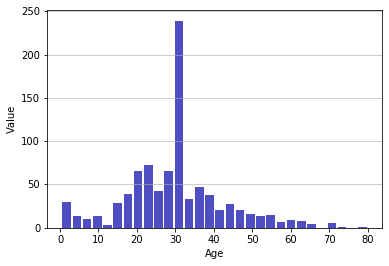

In [441]:
train = feature_engineer(train)

       PassengerId      Pclass         Sex    Embarked       normAge  \
count   418.000000  418.000000  418.000000  418.000000  4.180000e+02   
mean   1100.500000    2.265550    0.636364    1.401914 -2.477972e-15   
std     120.810458    0.841838    0.481622    0.854496  1.000000e+00   
min     892.000000    1.000000    0.000000    0.000000 -2.382564e+00   
25%     996.250000    1.000000    0.000000    1.000000 -5.756121e-01   
50%    1100.500000    3.000000    1.000000    2.000000 -2.530716e-15   
75%    1204.750000    3.000000    1.000000    2.000000  4.335268e-01   
max    1309.000000    3.000000    1.000000    2.000000  3.619240e+00   

            Title      binAge  FamilySize  
count  418.000000  418.000000  418.000000  
mean     0.732057    5.868421    0.335885  
std      0.972019    2.715866    0.607629  
min      0.000000    0.000000    0.000000  
25%      0.000000    4.000000    0.000000  
50%      0.000000    6.000000    0.000000  
75%      1.000000    7.750000    0.400000  

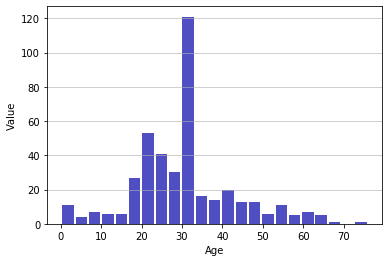

In [442]:
test = feature_engineer(test)

In [443]:
Y = train["Survived"]
X = train.drop(["Survived"],axis=1)
sub = pd.read_csv('C:/Users/Asus/Desktop/ughh!/kaggle-titanic/gender_submission.csv')

x_test = test
y_test = sub["Survived"]

# fit model no training data
model_xgb = XGBClassifier()
model_xgb.fit(X, Y)

# make predictions for test data
y_pred_xgb = model_xgb.predict(x_test)
predictions = [value for value in y_pred_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
y_pred_xgb.size

Accuracy: 84.21%


418

(array([ 64.,  19.,  96., 122.,  61., 312.,  67.,  47.,  39.,  64.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

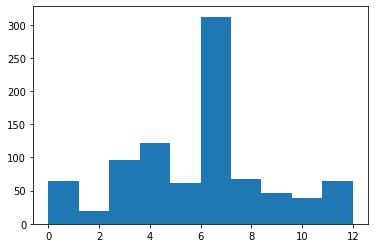

In [444]:
plt.hist(X["binAge"])

In [445]:
#LightGBM

train_data = lightgbm.Dataset(X, label=Y)
test_data = lightgbm.Dataset(x_test, label=y_test)

parameters = {
    'objective': 'binary',
    'num_iterations': 3,
    'num_leaves': 10,
    'metric': 'binary_error',
    'learning_rate': 11,
}

model_lgbm = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data)

y_pred_lgbm = model_lgbm.predict(X)[:418].round()
accuracy_lgbm= accuracy_score(y_test, y_pred_lgbm)
print("Accuracy_lgm: %.2f%%" % (accuracy_lgbm * 100.0))

y_pred_lgbm.round().size

[1]	valid_0's binary_error: 0.191388
[2]	valid_0's binary_error: 0.413876
[3]	valid_0's binary_error: 0.535885
Accuracy_lgm: 63.40%


C:\Users\Asus\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


418

In [446]:
random_forest = RandomForestClassifier(n_estimators = 100)

random_forest.fit(X,Y)


y_pred_rf=clf.predict(x_test)
print("Accuracy:",accuracy_score(y_test, y_pred_rf))
y_pred_rf

Accuracy: 0.0


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [447]:
NB = GaussianNB()  
NB.fit(X, Y)   
y_predict_nb = NB.predict(x_test)  
print("Accuracy NB: {:.2f}".format(NB.score(x_test, y_test)))
y_predict_nb

Accuracy NB: 0.92


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [448]:
final_pred = ((y_predict_nb + y_pred_xgb*1.1 )/2.1).round().astype(int)
final_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [449]:

sub["Survived"] = final_pred
sub.to_csv("cbon3ad.csv",index=False)